<a href="https://colab.research.google.com/github/0xtaha/image-super-resloution-for-remote-sensing/blob/main/Image_Super_Resolution_Using_Efficient_Sub_Pixel_CNN__UC_Merced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# check package versions
import sys
import matplotlib
from multiprocessing import Pool

print('Python: {}'.format(sys.version))
print('Matplotlib: {}'.format(matplotlib.__version__))

Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Matplotlib: 3.2.2


In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout,Activation
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import clear_session

from skimage.measure import compare_ssim as ssim
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import math
import os
import glob
import cv2
import pandas as pd


# python magic function, displays pyplot figures in the notebook
%matplotlib inline

In [ ]:

!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip


--2021-07-07 14:52:54--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip.5’

UCMerced_LandUse.zi 100%[===================>] 317.07M  75.6MB/s    in 4.7s    

2021-07-07 14:52:59 (67.4 MB/s) - ‘UCMerced_LandUse.zip.5’ saved [332468434/332468434]



In [ ]:

!unzip /content/UCMerced_LandUse.zip -d /content/
Land_images = glob.glob('/content/UCMerced_LandUse/Images/**/*.tif') #returns path of images
print(len(Land_images)) #contains 13243 images
#Os.remove('/content/UCMerced_LandUse/Images/airplane/airplane18.tif ')



Archive:  /content/UCMerced_LandUse.zip
replace /content/UCMerced_LandUse/Images/agricultural/agricultural00.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 2100


In [ ]:
def ssim(y_pred, y_true):
  return tf.image.ssim(y_true, y_pred , max_val=2.0)

def psnr(y_pred, y_true):
  return tf.image.psnr(y_true, y_pred , max_val=1.0)

In [ ]:
def Psnr(im1 , im2 , max_value = 1.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  psnr = tf.image.psnr(im1, im2, max_val= max_value)
  return float(psnr)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def SSIM(im1 , im2 , max_value = 2.0):
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  SSIM = tf.image.ssim(im1, im2, max_val= max_value)
  return float(SSIM)


def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref))
    
    return scores

In [ ]:
'''# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


SyntaxError: ignored

In [ ]:
# prepare degraded images by introducing quality distortions via resizing

from tqdm import tqdm
progress = tqdm(total= len(Land_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(256,256,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(10)
img_array = p.map(read, Land_images)


 10%|▉         | 208/2100 [00:12<00:46, 40.96it/s]

In [ ]:
def get_low_res(img , factor):
  # find old and new image dimensions
  h, w, _ = img.shape
  new_height = int(h / factor)
  new_width = int(w / factor)
          
  # resize the image - down
  img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
          
  # resize the image - up
  low_img_resloution = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
  return low_img_resloution


In [ ]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2 , train_size = 0.8)

In [ ]:
all_images.shape

(2100, 256, 256, 3)

In [ ]:
# get low resloution images for training
train_x_low = []

for i in range(train_x.shape[0]):
  temp = get_low_res(train_x[i,:,:,:] , 2)
  train_x_low.append(temp)
train_x_low = np.array(train_x_low)

val_x_low = []

for i in range(val_x.shape[0]):
  temp = get_low_res(val_x[i,:,:,:] , 2)
  val_x_low.append(temp)
val_x_low = np.array(val_x_low)



In [ ]:
del all_images
del img_array

In [ ]:
import gc
gc.collect()

180

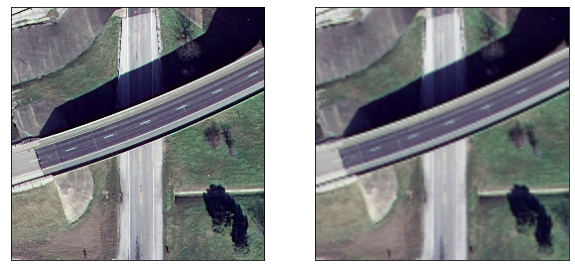

In [ ]:
n = 1
plt.figure(figsize= (10,10))
for i in range(n):
  ax = plt.subplot(1, 2, i+1)
  plt.imshow(train_x[i+30])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(1, 2, i+1+n)
  plt.imshow(train_x_low[i+30])

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
 
plt.show()


In [ ]:
# test the generated images using the image quality metrics

for i in range(val_x.shape[0]):
    
    # open target and reference images
    target = val_x_low[i,:,:,:]
    ref = val_x[i,:,:,:]
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(i, scores[0], scores[1], scores[2]))
    

0
PSNR: 23.030071258544922
MSE: 0.01493186075598669
SSIM: 0.6941754221916199

1
PSNR: 21.823944091796875
MSE: 0.019711827426923897
SSIM: 0.8461112380027771

2
PSNR: 30.284990310668945
MSE: 0.002809454900139306
SSIM: 0.9181753993034363

3
PSNR: 29.51736831665039
MSE: 0.0033526188102946932
SSIM: 0.9341846108436584

4
PSNR: 30.423471450805664
MSE: 0.0027212852742776183
SSIM: 0.9578366279602051

5
PSNR: 23.863813400268555
MSE: 0.012323665019521094
SSIM: 0.8336983323097229

6
PSNR: 25.32320213317871
MSE: 0.008806451618691355
SSIM: 0.8618208765983582

7
PSNR: 23.525283813476562
MSE: 0.013322720792632926
SSIM: 0.7652018666267395

8
PSNR: 27.647418975830078
MSE: 0.0051567886155181
SSIM: 0.924572229385376

9
PSNR: 44.927947998046875
MSE: 9.645531335334252e-05
SSIM: 0.9932723045349121

10
PSNR: 29.10578727722168
MSE: 0.003685889578398885
SSIM: 0.9351155757904053

11
PSNR: 34.07859420776367
MSE: 0.0011729018525294317
SSIM: 0.9564710259437561

12
PSNR: 28.642797470092773
MSE: 0.004100543639630837


In [ ]:
clear_session()

Input_img = Input(shape=(256, 256, 3))
'''C1 = Conv2D(64,(9,9),padding='SAME',name='CONV1')(Input_img)
A1 = Activation('relu', name='act1')(C1)
C2 = Conv2D(32,(1,1),padding='SAME',name='CONV2')(A1)
A2 = Activation('relu', name='act2')(C2)
C3 = Conv2D(1,(5,5),padding='SAME',name='CONV3')(A2)
A3 = Activation('relu', name='act3')(C3)'''

l1 = Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='Orthogonal',
                     activation='relu', padding='same', use_bias=True)(Input_img)
l2 = Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='Orthogonal',
                     activation='relu', padding='same', use_bias=True)(l1)
l3 = Conv2D(filters=32, kernel_size = (3, 3), kernel_initializer='Orthogonal',
                     activation='relu', padding='same', use_bias=True)(l2)
l4 = Conv2D(filters=12, kernel_size = (3, 3), kernel_initializer='Orthogonal',
                     activation='relu', padding='same', use_bias=True)(l3)
result = Conv2D(filters=3, kernel_size = (3, 3), kernel_initializer='Orthogonal',
                     activation='linear', padding='same', use_bias=True)(l4)
adam = Adam(lr=0.0001)

ESPCN = Model(Input_img, result )

# compile model
#ESPCN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
ESPCN.compile(optimizer=adam, loss='mean_squared_error', metrics=[ssim,psnr,'accuracy'])

   



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
ESPCN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 12)      3468      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 3)       327       
Total params: 64,051
Trainable params: 64,051
Non-trainable params: 0
_________________________________________________________

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)
#model = get_model(factor=factor, channels=3)
'''model.summary()

callbacks = [ESPCNCallback(), early_stopper, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)'''




'model.summary()\n\ncallbacks = [ESPCNCallback(), early_stopper, model_checkpoint_callback]\nloss_fn = keras.losses.MeanSquaredError()\noptimizer = keras.optimizers.Adam(learning_rate=0.001)'

In [ ]:
history = ESPCN.fit(train_x_low,train_x, 
            epochs=100,
            validation_data=(val_x_low, val_x),
            callbacks=[early_stopper, model_checkpoint])

 


Epoch 1/100
53/53 [==============================] - 16s 308ms/step - loss: 0.0014 - ssim: 0.9287 - psnr: 30.7786 - accuracy: 0.8567 - val_loss: 0.0015 - val_ssim: 0.9289 - val_psnr: 30.3091 - val_accuracy: 0.8574
Epoch 2/100
53/53 [==============================] - 17s 315ms/step - loss: 0.0014 - ssim: 0.9293 - psnr: 30.8468 - accuracy: 0.8576 - val_loss: 0.0015 - val_ssim: 0.9296 - val_psnr: 30.3690 - val_accuracy: 0.8503
Epoch 3/100
53/53 [==============================] - 17s 324ms/step - loss: 0.0014 - ssim: 0.9300 - psnr: 30.9017 - accuracy: 0.8562 - val_loss: 0.0015 - val_ssim: 0.9302 - val_psnr: 30.4191 - val_accuracy: 0.8636
Epoch 4/100
53/53 [==============================] - 17s 329ms/step - loss: 0.0014 - ssim: 0.9306 - psnr: 30.9747 - accuracy: 0.8597 - val_loss: 0.0015 - val_ssim: 0.9308 - val_psnr: 30.4229 - val_accuracy: 0.8390
Epoch 5/100
53/53 [==============================] - 17s 322ms/step - loss: 0.0013 - ssim: 0.9311 - psnr: 31.0312 - accuracy: 0.8619 - val_loss:

In [ ]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img
    

In [ ]:
val_x_low.shape


(420, 256, 256, 3)

In [ ]:
# define main prediction function

    
# load the ESsrcnn model with weights
ESPCN.load_weights('/content/superResolution_checkpoint3.h5')
    
predictions = ESPCN.predict(val_x_low)

In [ ]:
def predict(image_index):
  # image quality calculations
  ref = val_x[image_index]
  degraded = val_x_low[image_index]
  output = predictions[image_index]
  scores = []
  scores.append(compare_images(val_x_low[i], val_x[i]))
  scores.append(compare_images(predictions[i], val_x[i]))
    
  # return images and scores
  return ref, degraded, output, scores
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Degraded Image: 
PSNR: 32.10250473022461
MSE: 0.0018487185129421892
SSIM: 0.9471690058708191

Reconstructed Image: 
PSNR: 34.024715423583984
MSE: 0.0011875436596558203
SSIM: 0.9613924026489258



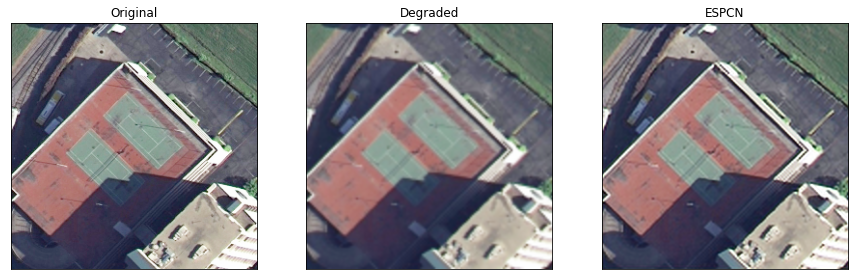

In [ ]:
ref, degraded, output, scores = predict(89)

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(ref)
axs[0].set_title('Original')
axs[1].imshow(degraded)
axs[1].set_title('Degraded')
axs[2].imshow(output)
axs[2].set_title('ESPCN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
sudo apt install git